# VarAnneal Tutorial

## Introduction
VarAnneal is a Python package for state and parameter estimation in partially observed dynamical systems and neural networks.  It uses variational annealing (VA), a variational data assimilation method.  VarAnneal is hosted on GitHub at [github.com/paulrozdeba/varanneal](http://github.com/paulrozdeba/varanneal).

In variational data assimilation, statistical path estimates conditioned on observational data are calculated using high-dimensional integrals of the form:
$$
\mathrm{E}\left[G(X) \lvert Y\right] = \frac{\int dX \: G(X)\: e^{-A(X,Y)}}{\int dX \: e^{-A(X,Y)}} \equiv \frac{1}{\mathcal{Z}(Y)} \int dX \: G(X)\: e^{-A(X,Y)}
$$
where $X$ is a vector of model states and parameters, and $Y$ is a vector of observational data.  These integrals may be approximated using Laplace's method around the dominant peaks of $P(X\lvert Y)$.  VA uses an annealing-like, numerical continuation method for finding these peaks using numerical optimization.  This optimization is carried out using one of a variety of methods, such as L-BFGS-B, NCG, IPOPT (future), ...   These methods require derivatives of $A$, which are computed with automatic differentiation (AD) using the PYADOLC wrapper around ADOL-C.

In dynamical systems, this amounts to estimating statistics for model parameters, as well as trajectories of model states, like the mode, mean, variance, ...  The data consists of time series of partial observations of the model variables.

In neural networks, this is used as a method of training the network weights on labeled data sets.

---

## Neural Network Example 1: All-to-All Feed-Forward Network for MNIST Image Recognition

In [2]:
# Necessary package imports
import time
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [3]:
from varanneal import va_nnet

#### Data
$M$ pairs of data, each consisting of a handwritten image (the input) and a label for the image, which is which digit a human decides the image is of (the output), forming the data $Y$.

#### Model
Here we use an all-to-all feed-forward neural network with 3 layers: one input, one output, and one hidden layer.  The input and output layer sizes are fixed by the number of pixels in each image and the number of possible labels, respectively.

The state of the network, $X$, is a collection of neuron activations in each layer:
$$
X = \left\{ \mathbf{x}^{l_1}, \mathbf{x}^{l_2}, \ldots, \mathbf{x}^{l_F} \right\}
$$

The state of the network in layer $l_n$ is transferred to layer $l_{n+1}$ according to the activation function:
$$
\mathbf{x}^{n+1} = \sigma(\mathbf{x}^{n}, \mathbf{W}^{n+1}) = \frac{1}{1 + \exp \left[-\mathbf{W}^{n+1} \cdot \mathbf{x}^n \right]}
$$
where $\mathbf{W}^n$ is the matrix of "synaptic" weights between layer $n-1$ and $n$.

#### Define the activation function

In [16]:
def sigmoid(x, W, b):
    linpart = np.dot(W, x) + b
    return 1.0 / (1.0 + np.exp(-linpart))

#### Network structure

In [17]:
N = 3  # Total number of layers
D_in = 3  # Number of neurons in the input layer
D_out = 4  # Number of neurons in the output layer
D_hidden = 30  # Number of neurons in the hidden layers

# Network structure is stored in a list, where element i is the number 
# of neurons in layer i.
structure = np.zeros(N, dtype='int')
structure[0] = D_in  # 3 neurons in the input layer
structure[N-1] = D_out  # 2 neurons in the output layer
for i in range(1, N-1):
    structure[i] = D_hidden  # 5 neurons in the hidden layers

Lidx = [np.linspace(0, D_in-1, D_in, dtype='int'), np.linspace(0, D_out-1, D_out, dtype='int')]

#### Action/annealing parameters

In [18]:
# RM, RF0
RM = 1.0
RF0 = 1.0e-8 * RM * float(np.sum(structure) - structure[0]) / float(structure[0] + structure[-1])
g0 = RF0 / RM

# alpha, and beta ladder
alpha = 1.1
beta_array = np.linspace(0, 435, 436)
gammas_all = g0 * alpha**beta_array

#### Load data set (3 in, 4 out)

In [19]:
M = 20  # number of training examples
data = np.load('l96/data/l96_data_N5.npy') # has 5 l96 variables
Didx = 0


T = data.shape[0]

data_in = np.zeros((M, D_in))
data_out = np.zeros((M, D_out))

for i in xrange(M):
    data_in[i] = data[i:i+D_in, Didx]
    data_out[i] = data[i+D_in:i+D_in+D_out, Didx]

#### Initial neuron activation/weight guesses

In [20]:
np.random.seed(27509436)

# Neuron states
Xin = np.random.randn(D_in)
Xin = (Xin - np.average(Xin)) / np.std(Xin)
X0 = np.copy(Xin)

for n in xrange(N-2):
    X0 = np.append(X0, 0.2*np.random.rand(D_hidden) + 0.4)
X0 = np.append(X0, 0.2*np.random.rand(D_out) + 0.4)

for m in xrange(M - 1):
    Xin = np.random.randn(D_in)
    Xin = (Xin - np.average(Xin)) / np.std(Xin)
    X0 = np.append(X0, Xin)
    for n in xrange(N-2):
        X0 = np.append(X0, 0.2*np.random.rand(D_hidden) + 0.4)
    X0 = np.append(X0, 0.2*np.random.rand(D_out) + 0.4)

X0 = np.array(X0).flatten()

# Parameters
NP = np.sum(structure[1:]*structure[:-1] + structure[1:])
P0 = np.array([], dtype=np.float64)

W_i0 = 0
W_if = structure[0]*structure[1]
b_i0 = W_if
b_if = b_i0 + structure[1]

# Set up Pidx so that only weights, not biases, are estimated
for n in xrange(N - 1):
    if n == 0:
        Pidx = np.arange(W_i0, W_if, 1, dtype='int')
    else:
        Pidx = np.append(Pidx, np.arange(W_i0, W_if, 1, dtype='int'))
    if n == 0:
        P0 = np.append(P0, (2.0*np.random.rand(structure[n]*structure[n+1]) - 1.0) / D_in)
    else:
        P0 = np.append(P0, (2.0*np.random.rand(structure[n]*structure[n+1]) - 1.0) / D_hidden)
    P0 = np.append(P0, np.zeros(structure[n+1]))

    if n < N - 2:
        W_i0 = b_if
        W_if = W_i0 + structure[n+1]*structure[n+2]
        b_i0 = W_if
        b_if = b_i0 + structure[n+2]

P0 = np.array(P0).flatten()
Pidx = np.array(Pidx).flatten().tolist()

### Use VA to train the network weights

In [21]:
# Initialize Annealer
anneal1 = va_nnet.Annealer()
# Set the network structure
anneal1.set_structure(structure)
# Set the activation function
anneal1.set_activation(sigmoid)
# Set the input and output data
anneal1.set_input_data(data_in)
anneal1.set_output_data(data_out)

#### Run VA using L-BFGS-B

In [22]:
BFGS_options = {'gtol':1.0e-12, 'ftol':1.0e-12, 'maxfun':1000000, 'maxiter':1000000}

tstart = time.time()
anneal1.anneal(X0, P0, alpha, beta_array, RM, RF0, Pidx, Lidx=Lidx,
               method='L-BFGS-B', opt_args=BFGS_options, adolcID=0)

print("\nADOL-C annealing completed in %f s."%(time.time() - tstart))

------------------------------
Step 1 of 436
beta = 0, RF = 4.85714286e-08

Taping action evaluation...
Done!
Time = 0.0810239315033 s

Beginning optimization...
Optimization complete!
Time = 0.0155999660492 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.28326951e-07]

------------------------------
Step 2 of 436
beta = 1, RF = 5.34285714e-08

Taping action evaluation...
Done!
Time = 0.0397341251373 s

Beginning optimization...
Optimization complete!
Time = 0.00589179992676 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  3.61159215e-07]

------------------------------
Step 3 of 436
beta = 2, RF = 5.87714286e-08

Taping action evaluation...
Done!
Time = 0.0417959690094 s

Beginning optimization...
Optimization complete!
Time = 0.00681900978088 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. functi

Iterations = 1
Obj. function value = [  3.69676666e-06]

------------------------------
Step 29 of 436
beta = 28, RF = 7.00448261e-07

Taping action evaluation...
Done!
Time = 0.0379741191864 s

Beginning optimization...
Optimization complete!
Time = 0.00674510002136 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  4.06644292e-06]

------------------------------
Step 30 of 436
beta = 29, RF = 7.70493087e-07

Taping action evaluation...
Done!
Time = 0.0331659317017 s

Beginning optimization...
Optimization complete!
Time = 0.0051281452179 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [  4.47308675e-06]

------------------------------
Step 31 of 436
beta = 30, RF = 8.47542396e-07

Taping action evaluation...
Done!
Time = 0.0312421321869 s

Beginning optimization...
Optimization complete!
Time = 0.00579118728638 s
Exit flag = 0
Exit message: CONVERGENCE

Optimization complete!
Time = 0.0245838165283 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [  7.76481366e-05]

------------------------------
Step 61 of 436
beta = 60, RF = 1.47891082e-05

Taping action evaluation...
Done!
Time = 0.0383818149567 s

Beginning optimization...
Optimization complete!
Time = 0.0217609405518 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 13
Obj. function value = [  8.54121854e-05]

------------------------------
Step 62 of 436
beta = 61, RF = 1.62680190e-05

Taping action evaluation...
Done!
Time = 0.0409910678864 s

Beginning optimization...
Optimization complete!
Time = 0.0105409622192 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [  9.39533363e-05]

------------------------------
Step 63 of 436
beta = 62, RF = 1.78948209e-05

Taping action evaluation...
Done!
Time = 0.0349559

Done!
Time = 0.0549199581146 s

Beginning optimization...
Optimization complete!
Time = 0.0146059989929 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 11
Obj. function value = [ 0.00111969]

------------------------------
Step 89 of 436
beta = 88, RF = 2.13273635e-04

Taping action evaluation...
Done!
Time = 0.0403079986572 s

Beginning optimization...
Optimization complete!
Time = 0.0111651420593 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 0.00123166]

------------------------------
Step 90 of 436
beta = 89, RF = 2.34600998e-04

Taping action evaluation...
Done!
Time = 0.0429811477661 s

Beginning optimization...
Optimization complete!
Time = 0.0187730789185 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 13
Obj. function value = [ 0.00135482]

------------------------------
Step 91 of 436
beta = 90, RF = 2.58061098e-04

Taping

Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.01212677]

------------------------------
Step 114 of 436
beta = 113, RF = 2.31075712e-03

Taping action evaluation...
Done!
Time = 0.0449721813202 s

Beginning optimization...
Optimization complete!
Time = 0.0120499134064 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.01333887]

------------------------------
Step 115 of 436
beta = 114, RF = 2.54183283e-03

Taping action evaluation...
Done!
Time = 0.0475649833679 s

Beginning optimization...
Optimization complete!
Time = 0.00894093513489 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.01467206]

------------------------------
Step 116 of 436
beta = 115, RF = 2.79601612e-03

Taping action evaluation...
Done!
Time = 0.0397548675537 s

Beginning optimization...
Optimization complete!
Time = 0.007

Done!
Time = 0.043643951416 s

Beginning optimization...
Optimization complete!
Time = 0.0109899044037 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.13083369]

------------------------------
Step 139 of 436
beta = 138, RF = 2.50363739e-02

Taping action evaluation...
Done!
Time = 0.0768611431122 s

Beginning optimization...
Optimization complete!
Time = 0.0134358406067 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.14384997]

------------------------------
Step 140 of 436
beta = 139, RF = 2.75400113e-02

Taping action evaluation...
Done!
Time = 0.0429611206055 s

Beginning optimization...
Optimization complete!
Time = 0.00802707672119 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 0.15815386]

------------------------------
Step 141 of 436
beta = 140, RF = 3.02940124e-02

Ta

Done!
Time = 0.0469319820404 s

Beginning optimization...
Optimization complete!
Time = 0.0116939544678 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 1.4837418]

------------------------------
Step 165 of 436
beta = 164, RF = 2.98387924e-01

Taping action evaluation...
Done!
Time = 0.0395510196686 s

Beginning optimization...
Optimization complete!
Time = 0.00791192054749 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 1.62352849]

------------------------------
Step 166 of 436
beta = 165, RF = 3.28226716e-01

Taping action evaluation...
Done!
Time = 0.0461628437042 s

Beginning optimization...
Optimization complete!
Time = 0.00640201568604 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 1.77560463]

------------------------------
Step 167 of 436
beta = 166, RF = 3.61049388e-01

T

Done!
Time = 0.0385489463806 s

Beginning optimization...
Optimization complete!
Time = 0.00716114044189 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 5
Obj. function value = [ 11.20978204]

------------------------------
Step 191 of 436
beta = 190, RF = 3.55623996e+00

Taping action evaluation...
Done!
Time = 0.0372440814972 s

Beginning optimization...
Optimization complete!
Time = 0.0106661319733 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 7
Obj. function value = [ 11.85693567]

------------------------------
Step 192 of 436
beta = 191, RF = 3.91186395e+00

Taping action evaluation...
Done!
Time = 0.0376670360565 s

Beginning optimization...
Optimization complete!
Time = 0.0106749534607 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 12.51368999]

------------------------------
Step 193 of 436
beta = 192, RF = 4.30305035e+00

Obj. function value = [ 25.16711839]

------------------------------
Step 218 of 436
beta = 217, RF = 4.66222852e+01

Taping action evaluation...
Done!
Time = 0.0279331207275 s

Beginning optimization...
Optimization complete!
Time = 0.00780606269836 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 6
Obj. function value = [ 25.40457303]

------------------------------
Step 219 of 436
beta = 218, RF = 5.12845137e+01

Taping action evaluation...
Done!
Time = 0.0333299636841 s

Beginning optimization...
Optimization complete!
Time = 0.00706720352173 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 25.62436284]

------------------------------
Step 220 of 436
beta = 219, RF = 5.64129650e+01

Taping action evaluation...
Done!
Time = 0.0355141162872 s

Beginning optimization...
Optimization complete!
Time = 0.00630903244019 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F

Beginning optimization...
Optimization complete!
Time = 0.00611782073975 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 27.80815924]

------------------------------
Step 245 of 436
beta = 244, RF = 6.11217888e+02

Taping action evaluation...
Done!
Time = 0.0282628536224 s

Beginning optimization...
Optimization complete!
Time = 0.00713801383972 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 27.83008322]

------------------------------
Step 246 of 436
beta = 245, RF = 6.72339676e+02

Taping action evaluation...
Done!
Time = 0.0341749191284 s

Beginning optimization...
Optimization complete!
Time = 0.0061981678009 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 27.85004414]

------------------------------
Step 247 of 436
beta = 246, RF = 7.39573644e+02

Taping action evaluation...
D

Done!
Time = 0.056932926178 s

Beginning optimization...
Optimization complete!
Time = 0.0100450515747 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.03719421]

------------------------------
Step 275 of 436
beta = 274, RF = 1.06653868e+04

Taping action evaluation...
Done!
Time = 0.0454950332642 s

Beginning optimization...
Optimization complete!
Time = 0.00892019271851 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 28.03847048]

------------------------------
Step 276 of 436
beta = 275, RF = 1.17319255e+04

Taping action evaluation...
Done!
Time = 0.0458550453186 s

Beginning optimization...
Optimization complete!
Time = 0.00631093978882 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 28.03963082]

------------------------------
Step 277 of 436
beta = 276, RF = 1.29051180e+04


Taping action evaluation...
Done!
Time = 0.0318191051483 s

Beginning optimization...
Optimization complete!
Time = 0.00539302825928 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 2
Obj. function value = [ 28.05016769]

------------------------------
Step 302 of 436
beta = 301, RF = 1.39823159e+05

Taping action evaluation...
Done!
Time = 0.0282430648804 s

Beginning optimization...
Optimization complete!
Time = 0.00562405586243 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.05026512]

------------------------------
Step 303 of 436
beta = 302, RF = 1.53805475e+05

Taping action evaluation...
Done!
Time = 0.0304131507874 s

Beginning optimization...
Optimization complete!
Time = 0.00699520111084 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.0503537]

------------------------------
Step 304 of 436
b

Step 334 of 436
beta = 333, RF = 2.95219496e+06

Taping action evaluation...
Done!
Time = 0.0409159660339 s

Beginning optimization...
Optimization complete!
Time = 0.00584387779236 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.05119338]

------------------------------
Step 335 of 436
beta = 334, RF = 3.24741446e+06

Taping action evaluation...
Done!
Time = 0.0282599925995 s

Beginning optimization...
Optimization complete!
Time = 0.00672483444214 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.05119757]

------------------------------
Step 336 of 436
beta = 335, RF = 3.57215590e+06

Taping action evaluation...
Done!
Time = 0.0285811424255 s

Beginning optimization...
Optimization complete!
Time = 0.00616002082825 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.05120139]


Optimization complete!
Time = 0.00688600540161 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.05123662]

------------------------------
Step 364 of 436
beta = 363, RF = 5.15140375e+07

Taping action evaluation...
Done!
Time = 0.0268769264221 s

Beginning optimization...
Optimization complete!
Time = 0.00622200965881 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.05123688]

------------------------------
Step 365 of 436
beta = 364, RF = 5.66654412e+07

Taping action evaluation...
Done!
Time = 0.0295970439911 s

Beginning optimization...
Optimization complete!
Time = 0.00736379623413 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.05123712]

------------------------------
Step 366 of 436
beta = 365, RF = 6.23319853e+07

Taping action evaluation...
Done!
Time = 0.02689409255

beta = 398, RF = 1.44766998e+09

Taping action evaluation...
Done!
Time = 0.0280110836029 s

Beginning optimization...
Optimization complete!
Time = 0.00580310821533 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 4
Obj. function value = [ 28.05123943]

------------------------------
Step 400 of 436
beta = 399, RF = 1.59243698e+09

Taping action evaluation...
Done!
Time = 0.032732963562 s

Beginning optimization...
Optimization complete!
Time = 0.00594305992126 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 3
Obj. function value = [ 28.05123944]

------------------------------
Step 401 of 436
beta = 400, RF = 1.75168068e+09

Taping action evaluation...
Done!
Time = 0.0283839702606 s

Beginning optimization...
Optimization complete!
Time = 0.00507116317749 s
Exit flag = 0
Exit message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Iterations = 1
Obj. function value = [ 28.05123945]

----------------

#### Save the output

In [29]:
anneal1.save_io("l96/results/io.npy")
anneal1.save_Wb("l96/results/W.npy", "l96/results/b.npy")
anneal1.save_action_errors("l96/results/action_errors.npy")

### Plot the results

In [30]:
# Load action curves
aerr = np.load("l96/results/action_errors.npy")

<IPython.core.display.Javascript object>


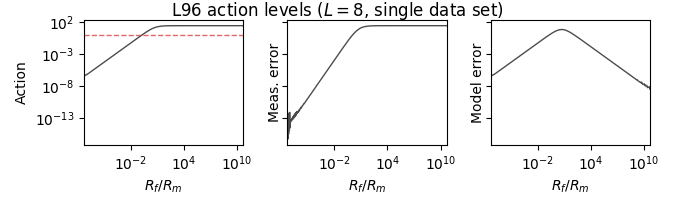

In [31]:
fig,ax = plt.subplots(1, 3, figsize=(6.75, 2.1), sharey=True)
fig.set_tight_layout(True)

ymin = 1.0e20
ymax = 0.0

plotlw = 1.0
plotalpha = .7
#plotcolors = ["C0", "C0", "C0"]
plotcolors = ["black", "black", "black"]

action_vals = aerr[:, 1]
ax[0].plot(gammas_all[:], action_vals, lw=plotlw, color=plotcolors[0], alpha=plotalpha)
ax[0].set_xlabel(r"$R_f/R_m$")
ax[0].set_ylabel("Action")
ax[0].axhline(y=1, lw=1, ls="--", color="C3", alpha=.7)

measerr_vals = aerr[:, 2]
ax[1].plot(gammas_all[:], measerr_vals, lw=plotlw, color=plotcolors[1], alpha=plotalpha)
ax[1].set_xlabel(r"$R_f/R_m$")
ax[1].set_ylabel("Meas. error")

moderr_vals = aerr[:, 3]
ax[2].plot(gammas_all[:], moderr_vals, lw=plotlw, color=plotcolors[2], alpha=plotalpha)
ax[2].set_xlabel(r"$R_f/R_m$")
ax[2].set_ylabel("Model error")

fig.suptitle("L96 action levels ($L=8$, single data set)", y=1.0)

for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlim(gammas_all[0], gammas_all[-1])
    #ax[i].set_ylim(.001, 1.0e2)

plt.show()

#### Parameter estimates

In [32]:
#structure = np.array([25, 3, 4])
Nbias = np.sum(structure[1:])
Nweight = np.sum(structure[1:] * structure[:-1])

sortedp = []

West = np.load("l96/results/W.npy")
best = np.load("l96/results/b.npy")

for i in xrange(len(gammas_all)):
    #West = np.load("W.npy")
    #best = np.load("b.npy")
    for j, West_n in enumerate(West[i]):
        if j == 0:
            pest = West_n.flatten()#, best_n.flatten())
        else:
            pest = np.append(pest, West_n.flatten())
    for j, best_n in enumerate(best[i]):
        pest = np.append(pest, best_n.flatten())
    sortedp.append(pest.flatten())

sortedp = np.array(sortedp)

In [33]:
fig,ax = plt.subplots(1, 1, figsize=(5,4))
fig.set_tight_layout(True)

nrange = range(Nweight + Nbias)
surf = ax.pcolormesh(gammas_all, nrange, np.abs(sortedp.T), rasterized=True, cmap='jet', norm=mplcolors.LogNorm())#, vmin=1.0E-7, vmax=1.0E3)
#surf = ax.pcolormesh(g, nrange, sortedp.T, rasterized=True, cmap='jet')#, norm=mplcolors.LogNorm())
ax.set_xscale("log")
ax.set_xlabel(r"$R_f/R_m$")
ax.set_ylabel(r"Parameter metaindex")
cbar = fig.colorbar(surf, ax=ax)
cbar.set_label(r"$W$")
ax.set_xlim((gammas_all[0], gammas_all[-1]))
ax.set_ylim((nrange[0], nrange[-1]))
#ax.set_title("Est. err. vs. data, sec%d mem%d"%(secID, ensID))

plt.show()
#fig.savefig("/home/prozdeba/Desktop/plots_20170801/nnet/params_M%d.pdf"%(Ntraining,))
#plt.close()

<IPython.core.display.Javascript object>

NameError: name 'mplcolors' is not defined

In [ ]:
### 